## Variational Quantum Classifier 

We will be using VQC to classify a two class problem using Quantum Machine Learning Variational Model with Ansatz (PQC)

In [77]:
import warnings

# Suppress warning
warnings.filterwarnings("ignore")

In [1]:
import numpy as np

#Importing standard Qiskit Libraries
from qiskit import QuantumCircuit, transpile, BasicAer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

### Loading IBM account
- If we want to run our code in Quantum Machine or Simulator and if we have IBM account we can load the account and check the available backend

In [3]:
# Loading IBM account
provider = IBMQ.load_account()
# Check the resource or provider that I have access to like Simulator as well as Quantum Machine
provider.backends()

/tmp/ipykernel_78/4147439836.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


#### The below section is required only if we want to run on hardware
-  As hardware is busy and need to wait in the queue, this will give you the least busy backend at IBM and run the quantum circuit there

In [64]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2 and b.status().operational==True))
print(backend)


ibmq_qasm_simulator


In [17]:
# Importing required packages for VQC Classifier

from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA  # classical optimizer
from qiskit.circuit.library import TwoLocal  # TwoLocal creates Ansartz
from qiskit_machine_learning.algorithms import VQC  # VQC classifer
from qiskit_machine_learning.datasets import *      # We will use wine sample data set
from qiskit_machine_learning.circuit.library import RawFeatureVector # Amplitude Encoding scheme classical data to quantum feature map
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal # Different Feture map 
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from sklearn.metrics import classification_report, confusion_matrix

from time import time
seed = 10599

In [21]:
simulator = BasicAer.get_backend('statevector_simulator')
print(simulator)

statevector_simulator


###  Importing sample data set to train our Model and split it to train and test data

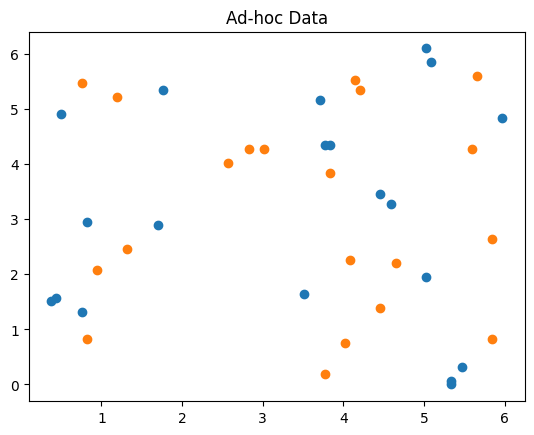

In [24]:

from qiskit_machine_learning.datasets import ad_hoc_data  

# Considering Two class problem Orange vs Blue ball and 2D input feature dataset
feature_dim = 2

# Splliting data to Train and Test - Train size 20, Test size 10
train_data, train_labels, test_data, test_labels = ad_hoc_data(
    training_size=20,
    test_size=10,
    n=feature_dim,
    gap=0.3,
    plot_data=True
)

### Our job here is to classify the above two class problem using VQC.
As we can see it is not possible to separate with a normal Line we need to represent this to feature map in high dimension using ansatz then we can draw a hyperplane to separate this two classes.

- If we have more data we can split it to validation data set as well

Let's see how our training and test data with labels sample look like after splitting

In [62]:
# Showing top 10 Training Data Sample
print("Showing 5 Random Training Data set  with Two feature 2D : x1 = Diameter of the ball, x2 = Density of the ball")
print(train_data[17:22]) 
print("Showing 5 Random Training Labels set")
print(train_labels[17:22])

Showing 5 Random Training Data set  with Two feature 2D : x1 = Diameter of the ball, x2 = Density of the ball
[[3.70707933 5.15221195]
 [3.51858377 1.63362818]
 [5.02654825 6.09468975]
 [4.20973416 5.34070751]
 [3.76991118 0.18849556]]
Showing 5 Random Training Labels set
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [47]:
# Showing top 10 Training Data Sample
print("Showing 5 Test Data set with Two feature 2D : x1 = Diameter of the ball, x2 = Density of the ball") 
print(test_data[8:13]) 
print("Showing 5 Test Labels set")
print(test_labels[8:13])

Top 5 Test Data set with Two feature 2D : x1 = Diameter of the ball, x2 = Density of the ball
[[1.75929189 2.63893783]
 [4.83805269 2.76460154]
 [1.75929189 4.58672527]
 [1.19380521 3.76991118]
 [4.0212386  0.9424778 ]]
Top 5 Test Labels set
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Here output labels is represented as One Hot Encoding that is belong to Two Class problem like either Blue Ball or Orange Ball
[1,0] - Class A or say Blue Ball
[0,1] - Class B or say Orange Ball

- For multiclass problem say we have 5 class and label is class -5 then output label will be [0,0,0,0,1] that's the way of one hot encoding 

In [67]:
# Checking the dimension of train and test data
print(train_data.shape)
print(test_data.shape)

(40, 2)
(20, 2)


#### Encoding classical data to quantum state using feature map

Z Feature Map is a quantum encoding technique using Angle Encoding that represents pairwise interactions between features by introducing ZZ gates between qubits. The number of qubits is typically equal to the number of dimensions in the input feature space. It uses entangling gate and represent feature in higher dimension.


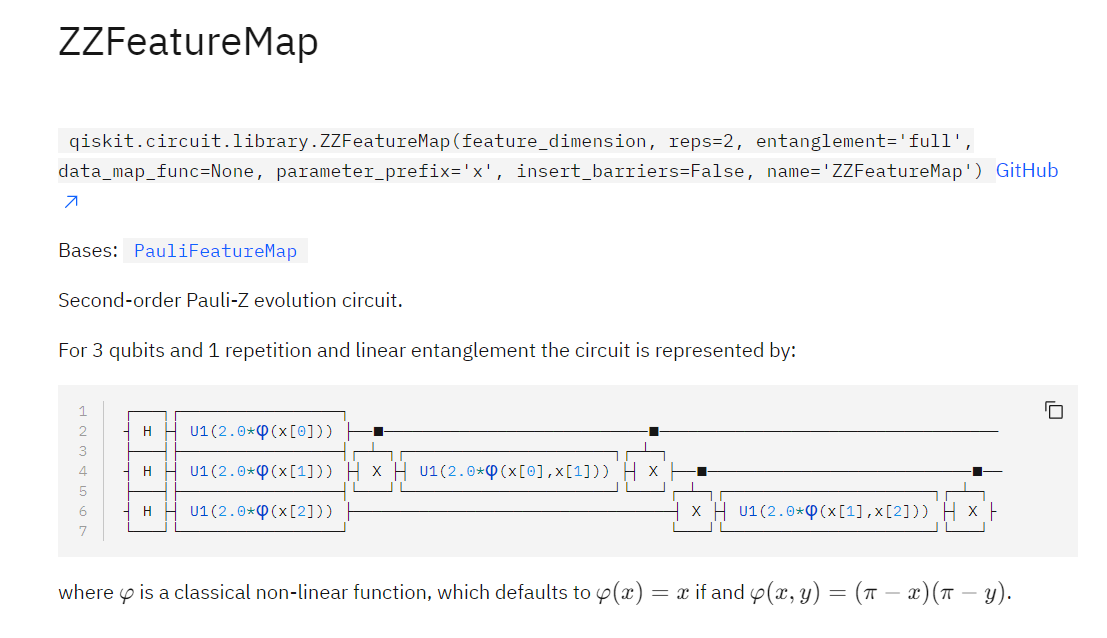

- However we can use other feature map as well like ZFeatureMap abd Amplitude encoding or higher order encoding or Binary Encoding
- In feature space angle of quantum state of qubit-1 will be function of X1 i.e. feature one Green ball
- In feature space angle of quantum state of qubit-2 will be function of X2 i.e. feature one Orange ball
- currently we have 40 data point for train data set so we will pass those data point one by one and encode that in qubit's   angle in feature space


In [74]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim)

### Applying PQC or Ansatz as variational Model whose parameter can be trained 

In [81]:
ansatz = TwoLocal(feature_dim, ['ry', 'rz'], 'cz')

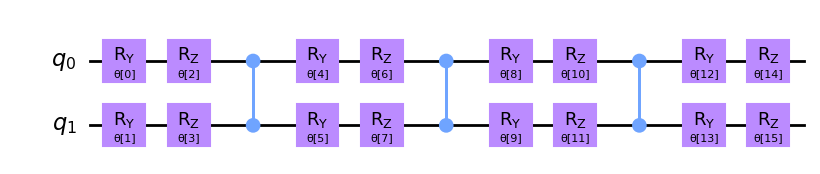

In [82]:
#Drawing Ansatz PQC
ansatz.decompose().draw()

### Applying Feature Map (Encoding Classcial Data) and Ansatz PQC to Variational Quantum Classifier (VQC)

- We are using classical Optimizer i.e. COBYLA (Constrained Optimization BY Linear Approximations) we can also use other gradient based optimizer like SPSA 

- **maxiter** is a parameter used with the COBYLA  optimizer. It represents the maximum number of iterations the optimizer is allowed to perform while trying to find the optimal solution. Setting maxiter to a specific value limits the optimization process to a certain number of iterations, which can be useful to control the computational cost or to stop the optimization after a certain number of steps.

-  As we increase shots or Maxiter our training time will increase

In [96]:
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=100),
          quantum_instance=QuantumInstance(backend=simulator, shots=100, seed_simulator=seed, seed_transpiler=seed)
         )
start_time = time()

# Training the Model using fit function
vqc.fit(train_data, train_labels)
end_time = time()
duration = end_time - start_time
print("Trainng time of VQC: ",duration)


Trainng time of VQC:  51.9952335357666


#### Prediction of test data set using our Trained Model 

In [97]:
result = vqc.predict(test_data)

In [98]:
result.shape

(20, 2)

#### Model Performance Matrices and Report

- Counfusion Matrix doesn't work for multilevel classification labels so we have get back to original form from One hot Encoding 

In [99]:
result_integer_labels = np.argmax(result, axis=1)
test_integer_labels = np.argmax(test_labels, axis=1)
print(result_integer_labels.shape)
print(test_integer_labels.shape)
print("test_integer_labels: ", test_integer_labels)
print("result_integer_labels: ", result_integer_labels)

(20,)
(20,)
test_integer_labels:  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
result_integer_labels:  [0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [100]:
print(classification_report(test_labels,result))
print(confusion_matrix(test_integer_labels,result_integer_labels))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

   micro avg       0.95      0.95      0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20
 samples avg       0.95      0.95      0.95        20

[[ 9  1]
 [ 0 10]]


#### Creating different Ansatz design

- When you use the skip_final_rotation_layer=True option in Qiskit's TwoLocal ansatz, it skips the final rotation layer during the creation of the circuit.

- The skip_final_rotation_layer option is more relevant when you have multiple repetitions (controlled by reps), and it allows you to skip the final rotation layer after all the repetitions. s

In [ ]:
#####  1. Simple Ansatz 

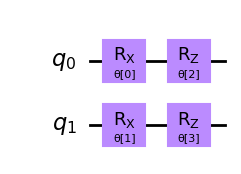

In [106]:
ansatz1 = TwoLocal(feature_dim,['rx','rz'], reps=1, skip_final_rotation_layer=True)
ansatz1.decompose().draw()

#####  2. Ansatz with 5 repetitions Entangling Gate

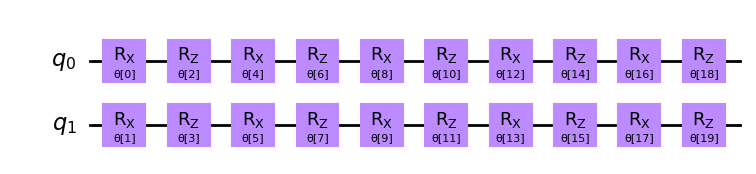

In [108]:
ansatz2 = TwoLocal(feature_dim,['rx','rz'], reps=5, skip_final_rotation_layer=True)
ansatz2.decompose().draw()

#####  3. Ansatz with Linear Entangling Gate

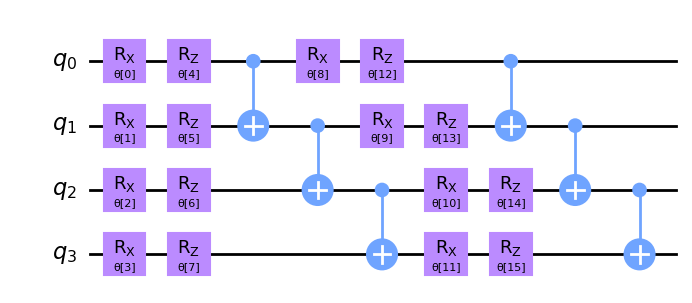

In [113]:
ansatz_linear_entangle = TwoLocal(4,['rx','rz'], 'cx', entanglement ='linear', reps=2, skip_final_rotation_layer=True)
ansatz_linear_entangle.decompose().draw()

#####  4. Ansatz with Circular Entangling Gate

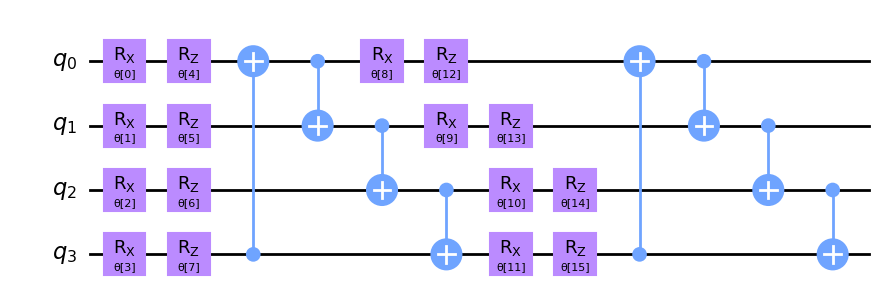

In [114]:
ansatz_circular_entangle = TwoLocal(4,['rx','rz'], 'cx', entanglement ='circular', reps=2, skip_final_rotation_layer=True)
ansatz_circular_entangle.decompose().draw()

#####  5. Ansatz with Full Entangling Gate

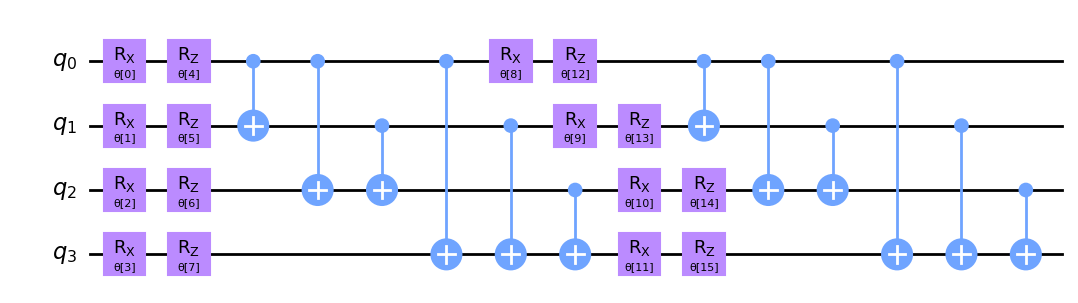

In [115]:
ansatz_full_entangle = TwoLocal(4,['rx','rz'], 'cx', entanglement ='full', reps=2, skip_final_rotation_layer=True)
ansatz_full_entangle.decompose().draw()